In [1]:
# PQCAnalyzer: Expressibility (KL, moments) & Entangling capability (Q) in one class
# - Qiskit 2.1.1 compatible
# - Uses qiskit.quantum_info.Statevector (no providers / no Aer required)
# - Matplotlib only, one chart per figure, no custom colors

from __future__ import annotations
import numpy as np
import math
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import (
    Statevector, DensityMatrix, partial_trace, state_fidelity
)

class PQCAnalyzer:
    """
    All-in-one analyzer for parameterized quantum circuits (PQC).
    Features:
      - Build a simple HEA ansatz (or plug your own)
      - Sample states, compute pairwise overlaps F = |<ψ|φ>|^2
      - KL expressibility vs Haar, frame-potential moments
      - Meyer–Wallach Q and entangling capability (mean Q)
      - Plots: F histogram vs Haar, moment comparison, Q histogram, Ent vs L

    Parameters
    ----------
    n : int
        Number of qubits.
    L : int
        Depth (number of layers).
    entangler : str
        'linear' (0->1->...->n-1) or 'full' (all-to-all chain).
    custom_ansatz : callable | None
        Optional function signature: custom_ansatz(n: int, L: int, theta: np.ndarray) -> QuantumCircuit
        If provided, overrides the internal ansatz generator.
    """

    # --------------- init & basic props ---------------
    def __init__(self, n: int, L: int, entangler: str = "linear", custom_ansatz=None):
        self.n = int(n)
        self.L = int(L)
        self.entangler = entangler
        self._custom_ansatz = custom_ansatz

    @property
    def d(self) -> int:
        """Hilbert space dimension."""
        return 2 ** self.n

    # --------------- ansatz builder ---------------
    def make_ansatz(self, theta: np.ndarray) -> QuantumCircuit:
        """
        Default hardware-efficient ansatz:
        For each layer: RY on all qubits + CX entanglers (linear or full).
        """
        if self._custom_ansatz is not None:
            return self._custom_ansatz(self.n, self.L, theta)

        qc = QuantumCircuit(self.n)
        it = iter(theta)
        for _ in range(self.L):
            for q in range(self.n):
                qc.ry(next(it), q)
            if self.entangler == "linear":
                for q in range(self.n - 1):
                    qc.cx(q, q + 1)
            elif self.entangler == "full":
                for c in range(self.n):
                    for t in range(c + 1, self.n):
                        qc.cx(c, t)
            else:
                raise ValueError("entangler must be 'linear' or 'full'")
        return qc

    def state_from_theta(self, theta: np.ndarray) -> Statevector:
        """Build statevector from parameters theta using the current ansatz."""
        qc = self.make_ansatz(theta)
        return Statevector.from_instruction(qc)

    # --------------- sampling utilities ---------------
    def sample_thetas(self, M: int, rng: np.random.Generator) -> np.ndarray:
        """Uniform parameters in [0, 2π). Shape (M, n*L)."""
        return rng.uniform(0, 2 * math.pi, size=(M, self.n * self.L))

    def sample_states(self, M: int, seed: int = 7) -> list[Statevector]:
        """Sample M parameter sets and return a list of Statevectors."""
        rng = np.random.default_rng(seed)
        thetas = self.sample_thetas(M, rng)
        return [self.state_from_theta(th) for th in thetas]

    # --------------- Haar references ---------------
    @staticmethod
    def haar_pdf(F: np.ndarray, d: int) -> np.ndarray:
        """Haar pdf of F = |<ψ|φ>|^2 in dimension d: (d-1)*(1-F)^(d-2)."""
        return (d - 1) * np.power(1.0 - F, d - 2)

    @staticmethod
    def haar_moment(t: int, d: int) -> float:
        """F^{(t)}_Haar = t! (d-1)! / (t + d - 1)! using log-gamma for stability."""
        from math import lgamma, exp
        return exp(lgamma(t + 1) + lgamma(d) - lgamma(t + d))

    @staticmethod
    def haar_Q_mean(n: int) -> float:
        """Haar average of Meyer–Wallach Q for n qubits: (N-2)/(N+1), N=2^n."""
        N = 2 ** n
        return (N - 2) / (N + 1)

    # --------------- pairwise F & moments ---------------
    @staticmethod
    def _pair_indices(M: int, num_pairs: int, rng: np.random.Generator):
        """Yield unique (i<j) pairs up to num_pairs (or all if None)."""
        S = M * (M - 1) // 2
        if (num_pairs is None) or (num_pairs >= S):
            for i in range(M):
                for j in range(i + 1, M):
                    yield i, j
            return
        seen = set()
        tries = 0
        while len(seen) < num_pairs and tries < 10 * num_pairs:
            i = rng.integers(0, M)
            j = rng.integers(0, M)
            if i == j:
                tries += 1
                continue
            a, b = (i, j) if i < j else (j, i)
            if (a, b) in seen:
                tries += 1
                continue
            seen.add((a, b))
        for pair in seen:
            yield pair

    @staticmethod
    def empirical_moments(Fs: np.ndarray, t_max: int = 3) -> np.ndarray:
        """Return [E[F^1], E[F^2], ..., E[F^t_max]]."""
        return np.array([float(np.mean(np.power(Fs, t))) for t in range(1, t_max + 1)])

    def sample_pairwise_F(self, states: list[Statevector], num_pairs: int | None = None,
                          seed: int = 7) -> np.ndarray:
        """Compute F=|<ψ|φ>|^2 over random (or all) unordered pairs of states."""
        rng = np.random.default_rng(seed)
        M = len(states)
        Fs = []
        for i, j in self._pair_indices(M, num_pairs, rng):
            Fs.append(state_fidelity(states[i], states[j]))
        return np.array(Fs, dtype=float)

    # --------------- KL expressibility & plots ---------------
    def kl_expressibility(self, Fs: np.ndarray, bins: int = 60) -> tuple[float, tuple[np.ndarray, np.ndarray, np.ndarray]]:
        """
        Continuous KL ≈ sum p_hat * log(p_hat/p_haar) * bin_width, using a density histogram.
        Returns: (kl, (centers, p_hat, p_haar))
        """
        hist, edges = np.histogram(Fs, bins=bins, range=(0.0, 1.0), density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        width = edges[1] - edges[0]
        p_hat = hist
        p_haar = self.haar_pdf(centers, self.d)
        eps = 1e-12
        kl = float(np.sum(p_hat * np.log((p_hat + eps) / (p_haar + eps))) * width)
        return kl, (centers, p_hat, p_haar)

    def plot_F_histogram(self, Fs: np.ndarray, bins: int = 60, title: str | None = None, savepath: str | None = None):
        """Plot empirical F histogram with Haar pdf overlay."""
        fig = plt.figure()
        plt.hist(Fs, bins=bins, range=(0.0, 1.0), density=True, alpha=0.6, label="Empirical F histogram")
        grid = np.linspace(0, 1, 400)
        plt.plot(grid, self.haar_pdf(grid, self.d), label="Haar pdf")
        plt.xlabel("F = |<psi|phi>|^2")
        plt.ylabel("Density")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    def plot_moment_comparison(self, Fs: np.ndarray, t_max: int = 3, title: str | None = None, savepath: str | None = None):
        """Bar chart: empirical E[F^t] vs Haar moments for t=1..t_max."""
        emp = self.empirical_moments(Fs, t_max=t_max)
        haar = np.array([self.haar_moment(t, self.d) for t in range(1, t_max + 1)])
        x = np.arange(1, t_max + 1, dtype=float)
        width = 0.35
        fig = plt.figure()
        plt.bar(x - width / 2, emp, width, label="Empirical")
        plt.bar(x + width / 2, haar, width, label="Haar")
        plt.xticks(x, [f"t={t}" for t in range(1, t_max + 1)])
        plt.ylabel("Moment  E[F^t]")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    # --------------- Meyer–Wallach Q & capability ---------------
    @staticmethod
    def _purity(dm: DensityMatrix) -> float:
        data = dm.data
        return float(np.real(np.trace(data @ data)))

    @staticmethod
    def meyer_wallach_Q(state_or_circuit) -> float:
        """
        Meyer–Wallach Q for a *pure* state.
        Accepts Statevector | numpy vector | QuantumCircuit.
        """
        if isinstance(state_or_circuit, Statevector):
            sv = state_or_circuit
        elif isinstance(state_or_circuit, QuantumCircuit):
            sv = Statevector.from_instruction(state_or_circuit)
        else:
            sv = Statevector(np.asarray(state_or_circuit))
        n = sv.num_qubits
        rho = DensityMatrix(sv)
        total = 0.0
        for j in range(n):
            others = [q for q in range(n) if q != j]
            rho_j = partial_trace(rho, others)
            total += (1.0 - PQCAnalyzer._purity(rho_j))
        Q = (2.0 / n) * total
        return float(np.clip(Q, 0.0, 1.0))

    def entangling_capability(self, M: int = 200, seed: int = 7) -> tuple[float, float, float, np.ndarray]:
        """
        Mean Q over M parameter samples (and std), with Haar benchmark.
        Returns: (Ent_mean, Ent_std, Haar_mean_Q, Qs_array)
        """
        rng = np.random.default_rng(seed)
        thetas = self.sample_thetas(M, rng)
        Qs = []
        for th in thetas:
            qc = self.make_ansatz(th)
            Qs.append(self.meyer_wallach_Q(qc))
        Qs = np.array(Qs, dtype=float)
        Ent_mean, Ent_std = float(np.mean(Qs)), float(np.std(Qs))
        return Ent_mean, Ent_std, self.haar_Q_mean(self.n), Qs

    # --------------- Q plots ---------------
    def plot_Q_histogram(self, Qs: np.ndarray, bins: int = 40, title: str | None = None, savepath: str | None = None):
        """Histogram of Q with Haar mean line."""
        q_haar = self.haar_Q_mean(self.n)
        fig = plt.figure()
        plt.hist(Qs, bins=bins, range=(0.0, 1.0), density=True, alpha=0.7, label="Empirical Q")
        plt.axvline(q_haar, linestyle="--", label=f"Haar mean Q = {q_haar:.3f}")
        plt.xlabel("Q (Meyer–Wallach)")
        plt.ylabel("Density")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    def plot_ent_vs_L(self, L_list, M: int = 300, seed: int = 7, savepath: str | None = None):
        """
        Sweep depth L and plot mean Q ± 1σ vs L with Haar mean line.
        Uses fresh random seeds per L for independence.
        """
        rng = np.random.default_rng(seed)
        means, stds = [], []
        for L in L_list:
            tmp = PQCAnalyzer(self.n, int(L), self.entangler, self._custom_ansatz)
            m, s, _, _ = tmp.entangling_capability(M=M, seed=int(rng.integers(0, 10_000_000)))
            means.append(m)
            stds.append(s)
        q_haar = self.haar_Q_mean(self.n)
        fig = plt.figure()
        plt.errorbar(L_list, means, yerr=stds, marker="o", linestyle="-", label="Mean Q ± 1σ")
        plt.axhline(q_haar, linestyle="--", label=f"Haar mean Q = {q_haar:.3f}")
        plt.xlabel("Depth L")
        plt.ylabel("Mean Q (Entangling capability)")
        plt.title(f"Entangling capability vs L (n={self.n}, entangler={self.entangler})")
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    # --------------- end-to-end helpers ---------------
    def run_expressibility_pipeline(self, M: int = 240, num_pairs: int = 5000,
                                   bins: int = 60, seed: int = 7,
                                   out_prefix: str | None = None):
        """
        Full pipeline:
          1) Sample M states
          2) Compute pairwise F over 'num_pairs' pairs (or all if None)
          3) KL to Haar + plots (hist & moment comparison)
        Returns:
          kl, Fs, (centers, p_hat, p_haar)
        """
        states = self.sample_states(M=M, seed=seed)
        Fs = self.sample_pairwise_F(states, num_pairs=num_pairs, seed=seed)
        kl, pack = self.kl_expressibility(Fs, bins=bins)

        if out_prefix is not None:
            self.plot_F_histogram(Fs, bins=bins,
                                  title=f"F histogram vs Haar (n={self.n}, L={self.L})",
                                  savepath=f"{out_prefix}_hist.png")
            self.plot_moment_comparison(Fs, t_max=3,
                                  title=f"Moment comparison (n={self.n}, L={self.L})",
                                  savepath=f"{out_prefix}_moments.png")
        return kl, Fs, pack

    def run_Q_pipeline(self, M: int = 300, bins: int = 40,
                       seed: int = 7, L_list=None, out_prefix: str | None = None):
        """
        Full Q/Ent pipeline:
          1) Mean Q ± std (entangling capability) and Q histogram
          2) Optionally Ent vs L curve if L_list provided
        """
        meanQ, stdQ, qH, Qs = self.entangling_capability(M=M, seed=seed)
        if out_prefix is not None:
            self.plot_Q_histogram(Qs, bins=bins,
                                  title=f"Q distribution (n={self.n}, L={self.L})",
                                  savepath=f"{out_prefix}_Qhist.png")
            if L_list is not None:
                self.plot_ent_vs_L(L_list, M=M, seed=seed,
                                   savepath=f"{out_prefix}_Ent_vs_L.png")
        return meanQ, stdQ, qH, Qs
    # === Add these methods inside PQCAnalyzer ===================================

    # ---------- Metric vs L (KL or Q) ----------
    def _KL_vs_L(self, L_list, M=240, num_pairs=5000, bins=60, seed=7):
        """Compute KL(L) across depths. Returns (Ls, KLs)."""
        rng = np.random.default_rng(seed)
        KLs = []
        for L in L_list:
            tmp = PQCAnalyzer(self.n, int(L), self.entangler, self._custom_ansatz)
            # independence per L (new seed)
            s = int(rng.integers(0, 10_000_000))
            states = tmp.sample_states(M=M, seed=s)
            Fs = tmp.sample_pairwise_F(states, num_pairs=num_pairs, seed=s)
            kl, _ = tmp.kl_expressibility(Fs, bins=bins)
            KLs.append(float(kl))
        return np.array(L_list, dtype=int), np.array(KLs, dtype=float)

    def _Q_vs_L(self, L_list, M=300, seed=7):
        """Compute mean Q(L) ± std. Returns (Ls, means, stds, haar_mean)."""
        rng = np.random.default_rng(seed)
        means, stds = [], []
        for L in L_list:
            tmp = PQCAnalyzer(self.n, int(L), self.entangler, self._custom_ansatz)
            s = int(rng.integers(0, 10_000_000))
            m, st, qh, _ = tmp.entangling_capability(M=M, seed=s)
            means.append(float(m)); stds.append(float(st))
        return (np.array(L_list, dtype=int),
                np.array(means, dtype=float),
                np.array(stds, dtype=float),
                self.haar_Q_mean(self.n))

    # ---------- Find saturation depth L* ----------
    @staticmethod
    def _find_saturation_L(L_list, values, metric="Q", eps=1e-2, window=2):
        """
        Detect first depth where 'window' consecutive improvements < eps.
        - metric='Q': improvement = values[i] - values[i-1] (we want ↑)
        - metric='KL': improvement = values[i-1] - values[i] (we want ↓)
        Returns L* (int) or None if not found.
        """
        vals = np.asarray(values, dtype=float)
        if metric.upper() == "KL":
            imp = vals[:-1] - vals[1:]      # decrease is good
        else:  # 'Q'
            imp = vals[1:] - vals[:-1]      # increase is good

        # sliding window condition: all recent improvements < eps
        count = 0
        for i in range(1, len(vals)):
            if imp[i-1] < eps:
                count += 1
            else:
                count = 0
            if count >= window:
                # first L where window-length small-improvement run is complete
                return int(L_list[i])
        return None

    # ---------- Plot with saturation marker ----------
    def _plot_with_saturation(self, L_list, y, metric="Q", yerr=None,
                              haar_line=False, L_star=None, title=None, savepath=None):
        """Single-figure plot with optional error bars, Haar line, and vertical L* marker."""
        fig = plt.figure()
        if yerr is not None:
            plt.errorbar(L_list, y, yerr=yerr, marker="o", linestyle="-", label=f"{metric} vs L")
        else:
            plt.plot(L_list, y, marker="o", linestyle="-", label=f"{metric} vs L")

        if haar_line and metric.upper() == "Q":
            qh = self.haar_Q_mean(self.n)
            plt.axhline(qh, linestyle="--", label=f"Haar mean Q = {qh:.3f}")

        if L_star is not None:
            plt.axvline(L_star, linestyle=":", label=f"Saturation L* = {L_star}")

        plt.xlabel("Depth L")
        plt.ylabel("Mean Q" if metric.upper()=="Q" else "KL to Haar")
        if title:
            plt.title(title)
        plt.legend()
        if savepath:
            plt.tight_layout()
            plt.savefig(savepath, dpi=160)

    # ---------- Public helpers ----------
    def find_and_plot_Q_saturation(self, L_list, M=300, seed=7,
                                   eps=1e-2, window=2, savepath=None):
        """
        Compute mean Q vs L, find saturation L*, and plot with markers.
        Returns: (L*, Ls, means, stds)
        """
        Ls, means, stds, qh = self._Q_vs_L(L_list, M=M, seed=seed)
        L_star = self._find_saturation_L(Ls, means, metric="Q", eps=eps, window=window)
        self._plot_with_saturation(Ls, means, metric="Q", yerr=stds,
                                   haar_line=True, L_star=L_star,
                                   title=f"Mean Q vs L (n={self.n}, entangler={self.entangler})",
                                   savepath=savepath)
        return L_star, Ls, means, stds

    def find_and_plot_KL_saturation(self, L_list, M=240, num_pairs=5000, bins=60,
                                    seed=7, eps=5e-3, window=2, savepath=None):
        """
        Compute KL vs L, find saturation L*, and plot with markers.
        Returns: (L*, Ls, KLs)
        """
        Ls, KLs = self._KL_vs_L(L_list, M=M, num_pairs=num_pairs, bins=bins, seed=seed)
        L_star = self._find_saturation_L(Ls, KLs, metric="KL", eps=eps, window=window)
        self._plot_with_saturation(Ls, KLs, metric="KL", yerr=None,
                                   haar_line=False, L_star=L_star,
                                   title=f"KL expressibility vs L (n={self.n}, entangler={self.entangler})",
                                   savepath=savepath)
        return L_star, Ls, KLs
# === End of additions =========================================================

KL expressibility: 0.16859682468890788
<Q>: 0.6692 ± 0.1703 (Haar mean 0.8235)


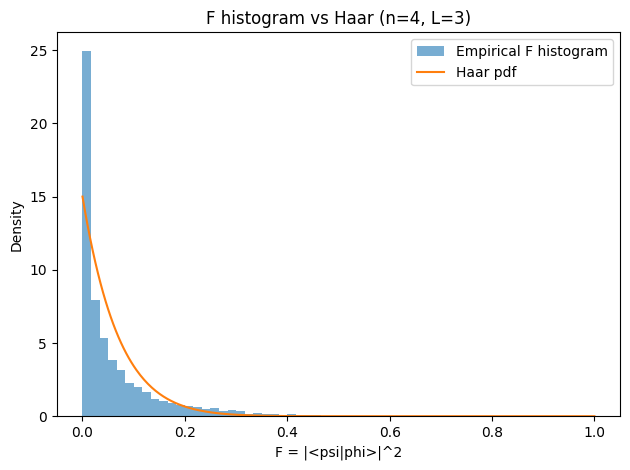

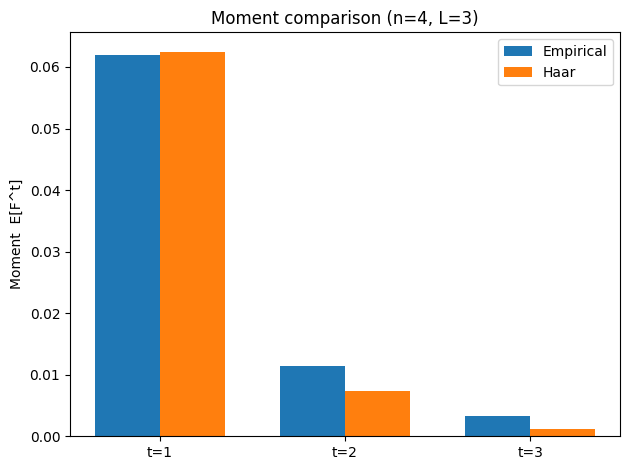

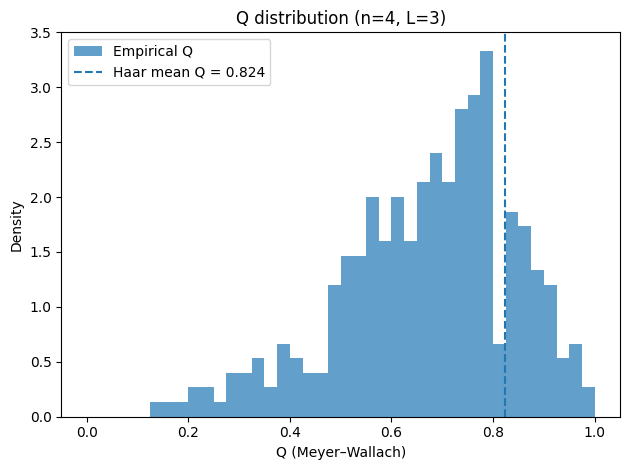

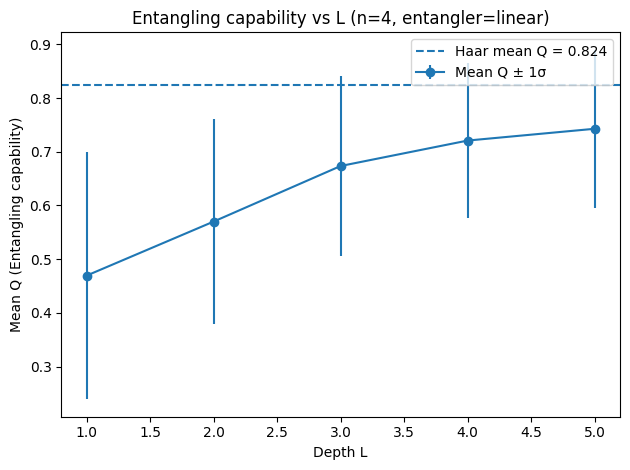

In [11]:
# 1) 클래스 초기화
an = PQCAnalyzer(n=4, L=3, entangler="linear")

# 2) 표현가능성 파이프라인: KL과 두 그림 저장
kl, Fs, _ = an.run_expressibility_pipeline(
    M=240, num_pairs=5000, bins=60, seed=7, out_prefix="expressibility"
)
print("KL expressibility:", kl)

# 3) 얽힘능력 파이프라인: 평균 Q, Q 히스토그램, Ent vs L 곡선
meanQ, stdQ, qH, Qs = an.run_Q_pipeline(
    M=300, bins=40, seed=7, L_list=[1,2,3,4,5], out_prefix="entangling"
)
print(f"<Q>: {meanQ:.4f} ± {stdQ:.4f} (Haar mean {qH:.4f})")

# Find saturation depth L* for Q

Q-saturation L* = 5
KL-saturation L* = 5


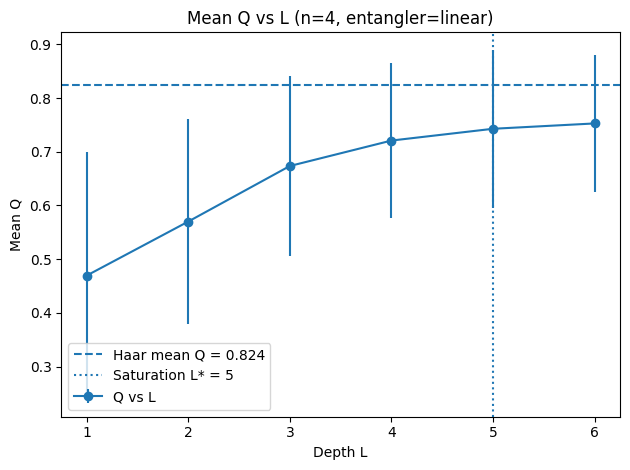

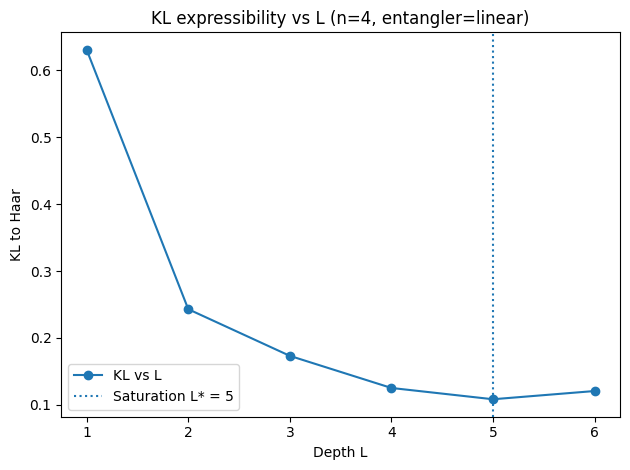

In [9]:
an = PQCAnalyzer(n=4, L=1, entangler="linear")

# 1) Q-기반 포화 깊이
L_star_Q, Ls, means, stds = an.find_and_plot_Q_saturation(
    L_list=[1,2,3,4,5,6], M=300, seed=7, eps=1e-1, window=2,
    savepath="Q_vs_L_with_saturation.png"
)
print("Q-saturation L* =", L_star_Q)

# 2) KL-기반 포화 깊이
L_star_KL, Ls, KLs = an.find_and_plot_KL_saturation(
    L_list=[1,2,3,4,5,6], M=240, num_pairs=5000, bins=60, seed=7,
    eps=5e-2, window=2, savepath="KL_vs_L_with_saturation.png"
)
print("KL-saturation L* =", L_star_KL)